# Project：Scrap the Historical Exchange rates From Money Policy Department of PBOC

## Description

In this Project, we try to scrap the Chinese inter-bank Exchange rates from website of Chinese central bank, which is maiitained by Money Policy Department.

It includes daily quots for USD/RMB, EUR/RMB, JPY/RMB, HKD/RMB, GPB/RMB, AUD/RMB, NZD/RMB, SGD/RMB, CFH/RMB, CAD/RMB.

After this, we try to use Principle Component Analysis to find out the main risk-factors of exchange rates of RMB.

**Main packages we use**: re, seleniumrequests, BeautifulSoup

**Webpage**: 

From http://www.pbc.gov.cn/zhengcehuobisi/125207/125217/125925/17105/index1.html
        
TO: http://www.pbc.gov.cn/zhengcehuobisi/125207/125217/125925/17105/index82.html

## Steps

Step 1：Data Collection：Scrap all the daily quots and save it into a DataFrame.

Step 2: DaTa Analysis: Use PCA to findout the main risk-factors of exchange ratets of RMB.

Step 3: Research and Report: Find out the distribution of these risk factors.






## Step 1: Scrap the quots

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import vars.var_ntime as nvar #my own package for analyze the Vars

import re
import requests
from bs4 import BeautifulSoup

In [32]:
# my main scape function
def my_scaper(addr,finaldf,webdriver):
    """
    this function will scrape exchange rates from MPD of PBOC:
    Step 1: scrape the webpage at addr
    Step 2: append the exchanges rates into the dataframe finaldf
    Step 3: return the finaldf
    """

    import re
    from bs4 import BeautifulSoup
    import requests
    import datetime
    import pandas as pd
    
    response = webdriver.request('GET',addr)
    # check the default encoding which is guessed by selenium:
    # print(response.encoding)
    # if not correct, specify the right encoding manually
    # in this case, the program guess encoding="ISO-8859-1", which is wrong
    # we must manually specify the response.encoding="utf-8"
    # response.text.encode('utf-8')  
    response.encoding="utf-8"
    # print(response.encoding)
    s = BeautifulSoup(response.text, 'lxml') # Use `lxml` to parse the webpage.
    # Find the date
    date=re.search(r"\d+年\d+月\d+日",s.text).group()

    # save the webpage locally for proofreading
    with open('Webpages/{}.html'.format(date), mode='wb') as fd:
        fd.write(response.content)
    
    date=datetime.datetime.strptime(date,"%Y年%m月%d日")

    # use the selector to findout the paragraph we need
    tag=s.select("#zoom > p:nth-child(1)")

    ## Find the quots
    quots=re.findall(r"1\w+对人民币\d+.\d+元",tag[0].get_text())
    df=pd.DataFrame()
    for quot in quots:
        temp=re.split(r"对人民币",quot)
        currency=temp[0][:]
        df[currency]=[temp[1][:-1]]
        df['date']=[date]
    df.set_index("date",inplace=True)
    df.index=pd.to_datetime(df.index)
    finaldf=pd.concat([finaldf,df],0)
    finaldf.sort_index(inplace=True)

    return finaldf



In [33]:
# test the sraper
addr1='http://www.pbc.gov.cn/zhengcehuobisi/125207/125217/125925/4192150/index.html'
fdf=pd.DataFrame()
## Import any WebDriver class imported from the seleniumrequests module
from seleniumrequests import Chrome
webdriver = Chrome()
fdf=my_scaper(addr1,fdf,webdriver)

In [34]:
fdf

,1美元,1欧元,100日元,1港元,1英镑,1澳大利亚元,1新西兰元,1新加坡元,1瑞士法郎,1加拿大元
date,,,,,,,,,,
2021-02-18,6.4536,7.7734,6.0968,0.83245,8.9464,5.0048,4.6418,4.8592,7.1832,5.0796


In [35]:
fdf=pd.DataFrame()

In [38]:
from seleniumrequests import Chrome
import re
from bs4 import BeautifulSoup
import requests
import datetime
import pandas as pd   
webdriver = Chrome()
for i in range(1,3):
    index1=r"http://www.pbc.gov.cn/zhengcehuobisi/125207/125217/125925/17105/index{}.html".format(i)              
    response = webdriver.request('GET',index1)
    response.encoding="utf-8"
    s = BeautifulSoup(response.text, 'lxml')

    hrefs={tag.get('href') for tag in s.find_all('a')}
    hrefs=list(hrefs)
    # select those useful links
    recomp=re.compile(r"/zhengcehuobisi/125207/125217/125925/\d+.*")
    hrefs=["http://www.pbc.gov.cn"+str(item) for item in hrefs if recomp.match(str(item))]
  
    for addr in hrefs:
        try:
            fdf=my_scaper(addr,fdf,webdriver)
        except:
            print("Fail at {}".format(addr))
            continue
fdf=fdf.astype('float')      

Fail at http://www.pbc.gov.cn/zhengcehuobisi/125207/125217/125925/2929357/index.html
Fail at http://www.pbc.gov.cn/zhengcehuobisi/125207/125217/125925/2929357/index.html


In [10]:
# with open('Webpages/index1.html', mode='wb') as fd:
#     fd.write(response.content)

In [43]:
fdf.columns=['USD','EUD','100JPY','HKD','GBP','AUD','NZD','SGD','CFH','CAD']
fdf.to_pickle("all_quots.pkl")
fdf.tail()

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
date,,,,,,,,,,
2021-02-08,6.4678,7.7891,6.1361,0.83426,8.8836,4.9642,4.6590,4.8482,7.1936,5.0699
2021-02-09,6.4533,7.7750,6.1301,0.83245,8.8657,4.9700,4.6586,4.8408,7.1778,5.0643
2021-02-10,6.4391,7.7996,6.1574,0.83064,8.8920,4.9806,4.6579,4.8560,7.2126,5.0711
2021-02-18,6.4536,7.7734,6.0968,0.83245,8.9464,5.0048,4.6418,4.8592,7.1832,5.0796
2021-02-19,6.4624,7.8162,6.1175,0.83358,9.0309,5.0223,4.6668,4.8732,7.2150,5.0987


## Data Analysis

In [3]:
quots=pd.read_pickle('all_quots.pkl')
quots.tail()

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
2021-02-05,6.4710,7.7423,6.1296,0.83466,8.8478,4.9207,4.6342,4.8402,7.1568,5.0462
2021-02-08,6.4678,7.7891,6.1361,0.83426,8.8836,4.9642,4.6590,4.8482,7.1936,5.0699
2021-02-09,6.4533,7.7750,6.1301,0.83245,8.8657,4.9700,4.6586,4.8408,7.1778,5.0643
2021-02-10,6.4391,7.7996,6.1574,0.83064,8.8920,4.9806,4.6579,4.8560,7.2126,5.0711
2021-02-18,6.4536,7.7734,6.0968,0.83245,8.9464,5.0048,4.6418,4.8592,7.1832,5.0796


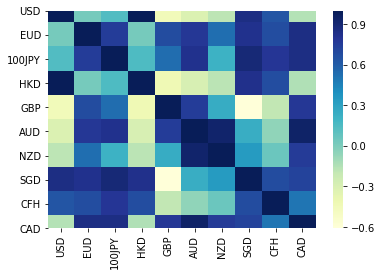

In [4]:
# Check the correlations 
import seaborn as sns
corrs=quots.corr()
sns.heatmap( corrs,cmap="YlGnBu")

As we can see HKD is hightly correlated with USD, which is inline with the fact that HKD/USD has been fixed.

But the other currencies do have floating exchange rates w.r.t. USD.

In [5]:
data=quots.dropna()
data

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
2015-11-10,6.3602,6.8397,5.1636,0.82048,9.6147,4.4807,4.1518,4.4700,6.3426,4.7908
2015-11-11,6.3614,6.8274,5.1688,0.82064,9.6264,4.4806,4.1629,4.4787,6.3255,4.7949
2015-11-12,6.3628,6.8467,5.1804,0.82095,9.6887,4.5256,4.1779,4.4880,6.3386,4.8018
2015-11-13,6.3655,6.8766,5.1945,0.82134,9.6930,4.5401,4.1641,4.4877,6.3590,4.7922
2015-11-16,6.3750,6.8349,5.2054,0.82251,9.6999,4.5322,4.1633,4.4744,6.3293,4.7839
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,6.4710,7.7423,6.1296,0.83466,8.8478,4.9207,4.6342,4.8402,7.1568,5.0462
2021-02-08,6.4678,7.7891,6.1361,0.83426,8.8836,4.9642,4.6590,4.8482,7.1936,5.0699
2021-02-09,6.4533,7.7750,6.1301,0.83245,8.8657,4.9700,4.6586,4.8408,7.1778,5.0643
2021-02-10,6.4391,7.7996,6.1574,0.83064,8.8920,4.9806,4.6579,4.8560,7.2126,5.0711


In [6]:
# Mean Normalization, so that the features centers in the original point
dmean=data.mean(axis=0)
dstd=data.std(axis=0)
data=(data-dmean)/dstd

In [7]:
# PCA

from numpy import linalg
U,sigma,VT=linalg.svd(1/len(data)*np.dot(data.T,data))

In [8]:
# Components
components=pd.DataFrame(U.T,columns=data.columns)
components=components.T
components.columns=['CP'+str(item+1) for item in components.columns]
components

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10
USD,-0.372618,0.181218,0.423622,-0.093614,0.139887,-0.268075,-0.218372,0.073964,-0.162414,-0.684930
EUD,-0.297440,-0.003021,-0.708585,0.005891,0.097104,-0.320837,-0.353199,0.055696,-0.403139,0.081579
100JPY,-0.385592,0.100017,0.002183,0.249809,-0.338694,0.639864,0.108854,0.332630,-0.362538,-0.028988
HKD,-0.365586,0.187362,0.460991,-0.100066,-0.029530,-0.287031,-0.066439,0.078204,-0.109563,0.709171
GBP,0.197068,0.310226,-0.080424,-0.851926,-0.245628,0.199105,-0.119832,0.040250,-0.128613,-0.013478
AUD,-0.069466,-0.630395,0.015247,-0.242586,-0.153091,-0.170331,0.016599,0.668320,0.195917,-0.030592
NZD,-0.135052,-0.595812,0.179082,-0.100213,-0.282284,0.153153,-0.334322,-0.578563,-0.186782,0.011097
SGD,-0.408413,0.066022,-0.118699,-0.100867,0.311116,0.385180,-0.393578,-0.017183,0.632297,0.066504
CFH,-0.364693,0.161801,-0.213174,-0.005101,-0.625707,-0.290877,0.312817,-0.228296,0.393068,-0.121476
CAD,-0.358677,-0.207062,-0.087359,-0.337514,0.451288,0.091116,0.657371,-0.198111,-0.153460,-0.005639


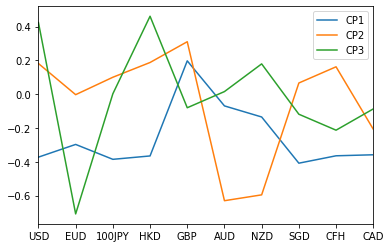

In [9]:
# Draw the components
components.plot(y=['CP1','CP2','CP3'])

In [10]:
# Check how much variation each component explains
#Total Variation
weights=[]
var=np.sum(data.values.flatten()**2)
for i in range(1,11):
    # Use the i-th components
    data_temp=np.dot(data,components[['CP{}'.format(i)]])
    data_temp=np.dot(data_temp,components[['CP{}'.format(i)]].T)

    # How much information captured
    var_temp=np.sum(data_temp.flatten()**2)
    weights.append(var_temp/var)


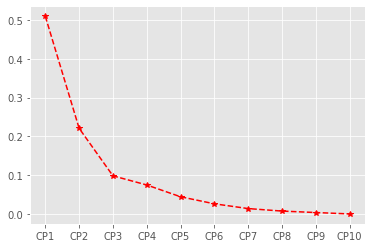

In [11]:
import matplotlib as mpl
mpl.style.use(['ggplot'])
plt.plot(components.columns,weights,'r*--')

In [13]:
#  reverse the Normalization process for Components
df_reverse=pd.concat([dmean,dstd],1)
df_reverse.columns=['dmean','dstd']
reverse_components=(components.T*df_reverse['dstd']+df_reverse['dmean']).T
reverse_components

def my_reverse(cps):
    # this function reverse the mean,normalization process above
    global df_reverse
    temp=(cps.T*df_reverse['dstd']+df_reverse['dmean']).T
    return temp

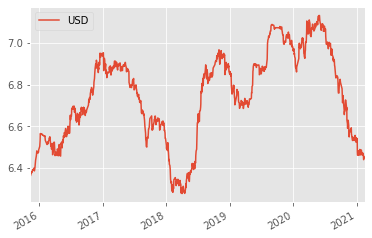

In [15]:
# For USD, lets see how much information is captured by the components/risk-factors:
quots.dropna().plot(y=['USD'])



In [16]:
# Approximation with the first two components:
approx_2=data.dot(components.iloc[:,:2]).dot(components.iloc[:,:2].T)
approx_2

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
2015-11-10,-2.210717,-2.145288,-2.513228,-2.144350,2.215706,-2.123853,-2.506050,-2.764835,-2.203807,-3.111205
2015-11-11,-2.212034,-2.141973,-2.512004,-2.145924,2.204399,-2.104465,-2.486973,-2.762358,-2.204636,-3.101195
2015-11-12,-2.200327,-2.116225,-2.490169,-2.135501,2.153104,-2.028509,-2.409255,-2.734798,-2.191450,-3.047552
2015-11-13,-2.173191,-2.099988,-2.465302,-2.108526,2.153665,-2.047842,-2.423713,-2.709925,-2.165462,-3.035441
2015-11-16,-2.204943,-2.131511,-2.501820,-2.139279,2.187443,-2.081543,-2.462890,-2.750274,-2.197190,-3.081963
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,-0.401899,-0.263694,-0.382045,-0.398014,0.055494,0.181969,0.110189,-0.389217,-0.387332,-0.239304
2021-02-08,-0.368143,-0.209235,-0.330810,-0.366677,-0.038012,0.312004,0.245665,-0.327513,-0.351394,-0.135735
2021-02-09,-0.421833,-0.242220,-0.380519,-0.419993,-0.036765,0.346399,0.270431,-0.377495,-0.402902,-0.161910
2021-02-10,-0.383298,-0.211536,-0.340688,-0.382180,-0.056934,0.353237,0.284053,-0.335328,-0.365195,-0.125016


In [17]:
# reverse the mean-normalization process, to findout the real approximations
reverse_approx_2=approx_2.apply(lambda t: my_reverse(t),axis=1)
reverse_approx_2

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
2015-11-10,6.261282,7.079018,5.371175,0.804187,9.493020,4.485751,4.134695,4.545060,6.285598,4.627119
2015-11-11,6.260994,7.079911,5.371559,0.804142,9.489777,4.489687,4.138227,4.545396,6.285358,4.628712
2015-11-12,6.263555,7.086849,5.378412,0.804439,9.475067,4.505109,4.152614,4.549138,6.289183,4.637247
2015-11-13,6.269491,7.091224,5.386218,0.805209,9.475228,4.501184,4.149938,4.552515,6.296722,4.639174
2015-11-16,6.262545,7.082730,5.374755,0.804331,9.484915,4.494341,4.142685,4.547037,6.287518,4.631772
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,6.656981,7.585993,6.040099,0.854024,8.873528,4.953914,4.619029,4.867601,6.812557,5.084074
2021-02-08,6.664365,7.600666,6.056181,0.854919,8.846713,4.980316,4.644109,4.875978,6.822983,5.100553
2021-02-09,6.652620,7.591779,6.040578,0.853397,8.847071,4.987299,4.648694,4.869192,6.808040,5.096388
2021-02-10,6.661050,7.600046,6.053080,0.854476,8.841287,4.988688,4.651216,4.874917,6.818979,5.102258


In [18]:
quots_dropna=quots.dropna()

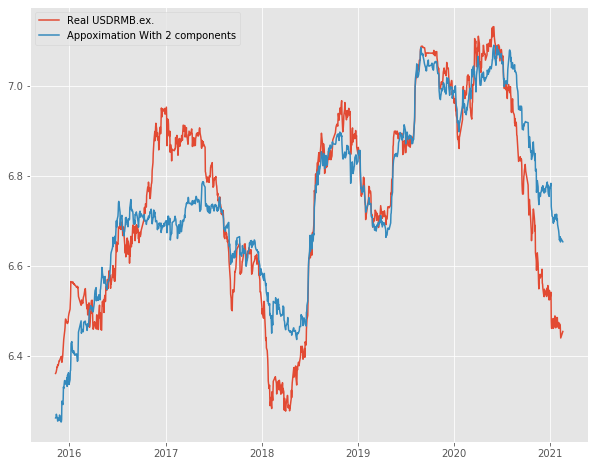

In [20]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(quots_dropna['USD'])
plt.plot(reverse_approx_2['USD'])
plt.legend(['Real USDRMB.ex.','Appoximation With 2 components'])

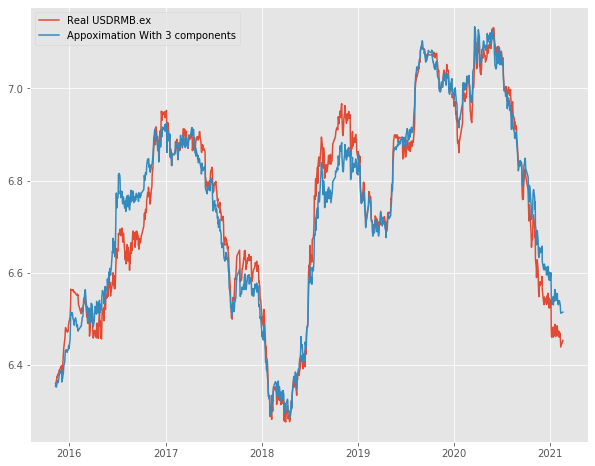

In [21]:
# Approximation USDRMB.ex with the first Three components:
approx_3=data.dot(components.iloc[:,:3]).dot(components.iloc[:,:3].T)
reverse_approx_3=approx_3.apply(lambda t: my_reverse(t),axis=1)
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(quots_dropna['USD'])
plt.plot(reverse_approx_3['USD'])
plt.legend(['Real USDRMB.ex','Appoximation With 3 components'])

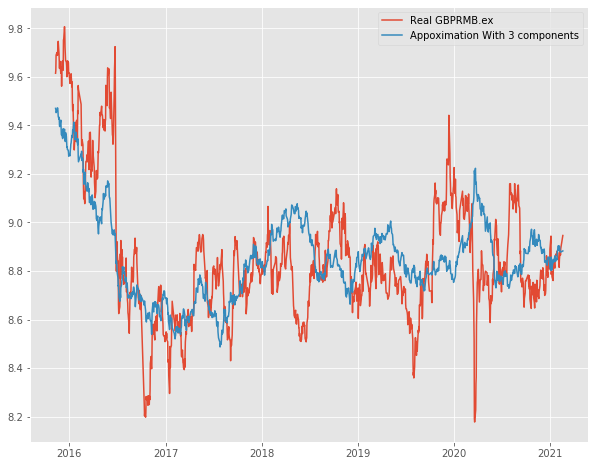

In [29]:
# Approximation GBPRMB.ex with the first Three components:
plt.plot(quots_dropna['GBP'])
plt.plot(reverse_approx_3['GBP'])
plt.legend(['Real GBPRMB.ex','Appoximation With 3 components'])

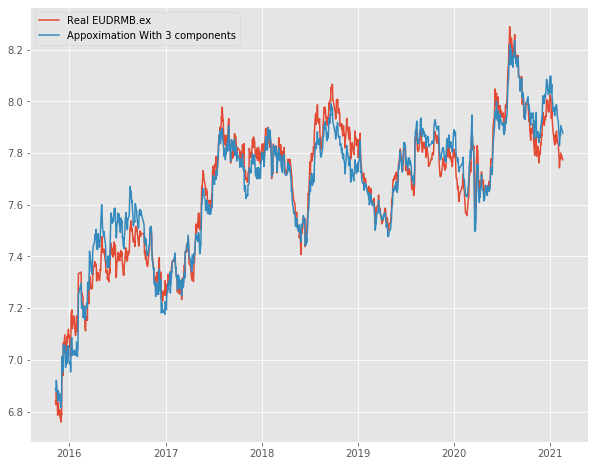

In [30]:
# Approximation EUDRMB.ex with the first Three components:
plt.plot(quots_dropna['EUD'])
plt.plot(reverse_approx_3['EUD'])
plt.legend(['Real EUDRMB.ex','Appoximation With 3 components'])

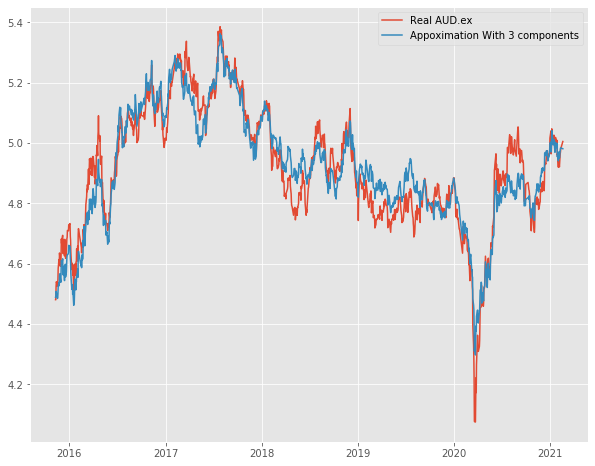

In [28]:
# Approximation JPYRMB.ex with the first Three components:
plt.plot(quots_dropna['AUD'])
plt.plot(reverse_approx_3['AUD'])
plt.legend(['Real AUD.ex','Appoximation With 3 components'])

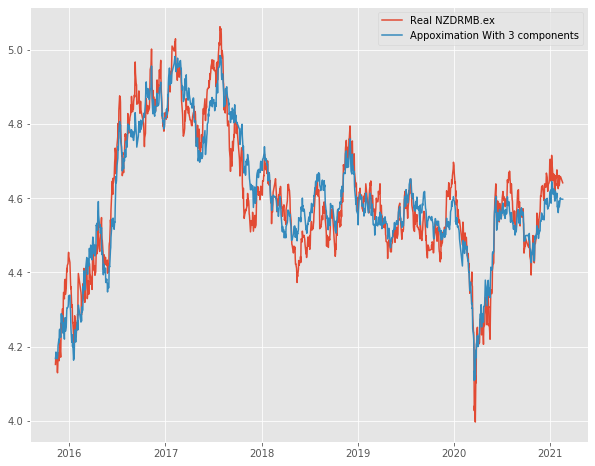

In [27]:
# Approximation JPYRMB.ex with the first Three components:
plt.plot(quots_dropna['NZD'])
plt.plot(reverse_approx_3['NZD'])
plt.legend(['Real NZDRMB.ex','Appoximation With 3 components'])

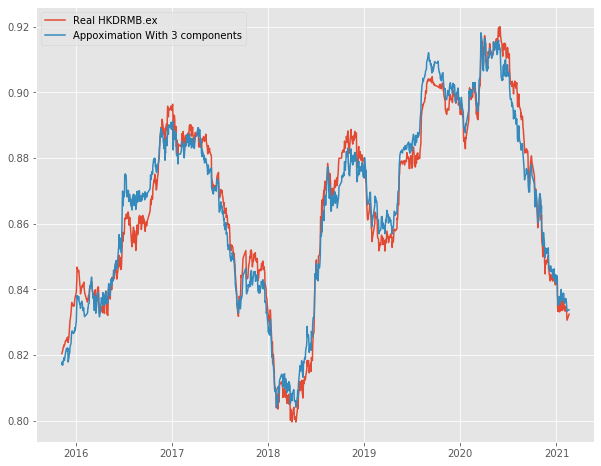

In [26]:
# Approximation JPYRMB.ex with the first Three components:
plt.plot(quots_dropna['HKD'])
plt.plot(reverse_approx_3['HKD'])
plt.legend(['Real HKDRMB.ex','Appoximation With 3 components'])

In [22]:
# Regard the first 3-components as risk-factor
# Analyze the economic meaning and dristibution of these risk factor
risk_factors=data.dot(components.iloc[:,:3])
risk_factors.head()

,CP1,CP2,CP3
2015-11-10,7.186323,2.577190,0.998583
2015-11-11,7.175480,2.547630,1.046032
2015-11-12,7.090043,2.436554,0.981948
2015-11-13,7.035078,2.473280,0.892018
2015-11-16,7.140635,2.515108,1.073761


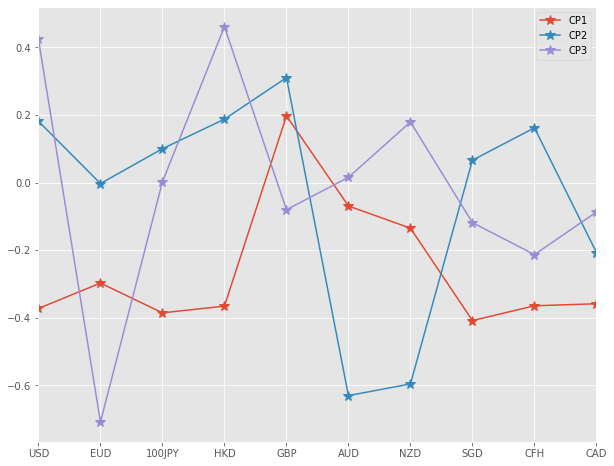

In [25]:
# Economic Meaning
## # Draw the components
components.plot(y=['CP1','CP2','CP3'],marker="*",markersize=10)


From the graph above, we can find that the first 3 components represent the following changes in exchange rates.

**CP1**: An increase in GBP, and decreases in USD,EUD,JPY,HKD,SGD,CFH,CAD

**CP2**: Huge Decrease in AUD NZD

**CP3**: Huge Dcrease in EUD, Incrase in USD and HKD

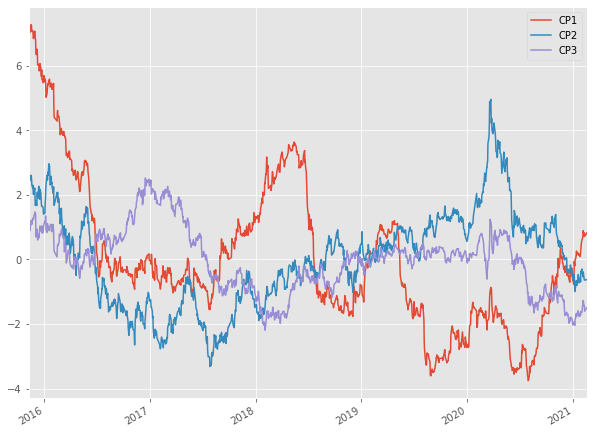

In [24]:
# How these risk-fatocrs behave
risk_factors.plot(y=['CP1','CP2','CP3'])

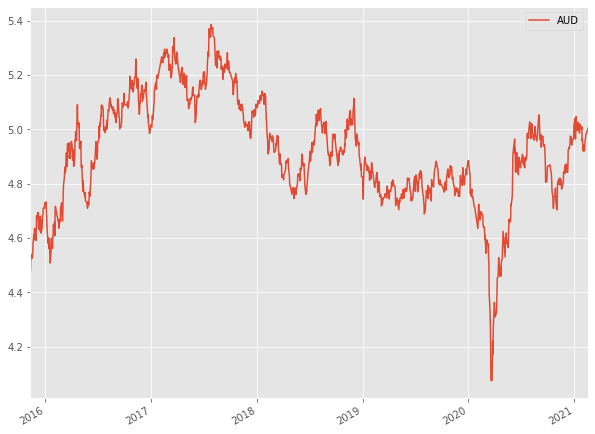

In [23]:
plt.rcParams['figure.figsize'] = (10,8)
quots_dropna.plot(y=['AUD'])

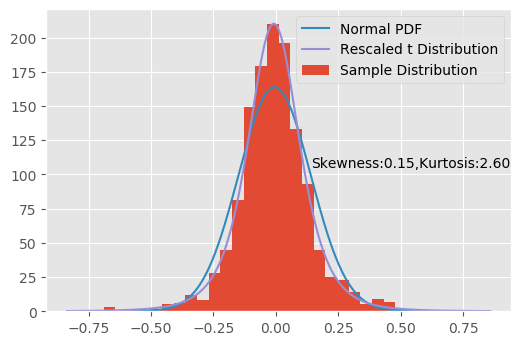

In [360]:
# How these risk-fatocrs changes on a daily basis
nvar.myhist(risk_factors['CP1'].diff().dropna())

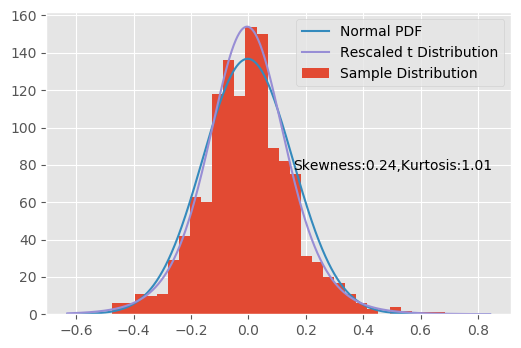

In [361]:
# How these risk-fatocrs changes on a daily basis
nvar.myhist(risk_factors['CP2'].diff().dropna())

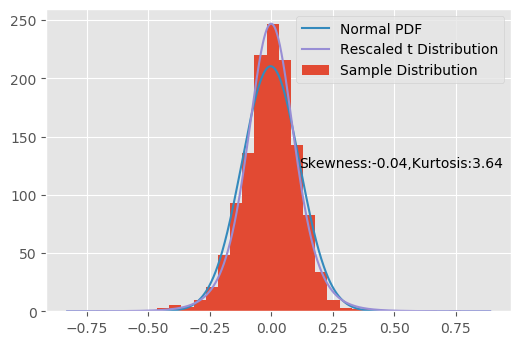

In [362]:
# How these risk-fatocrs changes on a daily basis
nvar.myhist(risk_factors['CP3'].diff().dropna())

In [31]:
# the correlation matrix of daily change in CP1\CP2\CP3
risk_factors.diff().dropna().corr()

,CP1,CP2,CP3
CP1,1.000000,0.394310,0.276036
CP2,0.394310,1.000000,0.149159
CP3,0.276036,0.149159,1.000000


In [32]:
# Covariance matrix of daily change in CP1,CP2,CP3
risk_factors.diff().dropna().cov()

,CP1,CP2,CP3
CP1,0.021088,0.009005,0.004701
CP2,0.009005,0.024729,0.002751
CP3,0.004701,0.002751,0.013755


In [33]:
C=linalg.cholesky(risk_factors.diff().dropna().cov())

In [34]:
print(C)
print('++++++++++++++++++++++++')
print(np.dot(C,C.T))

[[0.14521795 0.         0.        ]
 [0.06200698 0.14451305 0.        ]
 [0.03237404 0.00514513 0.11260783]]
++++++++++++++++++++++++
[[0.02108825 0.00900453 0.00470129]
 [0.00900453 0.02472889 0.00275095]
 [0.00470129 0.00275095 0.01375507]]


In [35]:
import scipy.stats as stats
print("means for daily changes in 3 componets:\t",stats.describe(risk_factors.diff().dropna()).mean)
print("variance for daily changes 3 componets:\t",stats.describe(risk_factors.diff().dropna()).variance)

means for daily changes in 3 componets:	 [-0.00495649 -0.00249386 -0.00193966]
variance for daily changes 3 componets:	 [0.02108825 0.02472889 0.01375507]


In [451]:
rv=np.dot(C,stats.norm.rvs(size=3))
# rv=np.dot(rv,components.iloc[:,:3].T)
# rv
delta_ex=components.iloc[:,:3].dot(rv)*dstd
delta_ex



USD      -0.007874
EUD       0.047662
100JPY    0.014818
HKD      -0.001258
GBP       0.002615
AUD      -0.005130
NZD      -0.009183
SGD       0.009869
CFH       0.026562
CAD       0.007612
dtype: float64

In [489]:
# Use montecarlo simulation to analyze the daily Var
# Mainly use the first 3 risk-factors
def myvar(C,dstd,components,num_of_sim=10000):
    # COV=C*C'
    # dstd is the standard deviation of the real ex quots
    # num_of_sim is the number of simulation
    # componetns is the first 3 principle components of normalized ex quots
    result=pd.DataFrame(columns=quots_dropna.columns)
    for i in range(num_of_sim):
        # simulate daily change in risk factor
        # Use the covariance to capture the correlation involved
        rv=np.dot(C,stats.norm.rvs(size=3))
        # Use the change in risk-factor, back to the change in real exchange rates
        delta_ex=components.iloc[:,:3].dot(rv)*dstd
        result=result.append(delta_ex,ignore_index=True)
    
    return result
        
        

In [470]:
result=myvar(C,dstd,components)

In [486]:
# Vars from PCA （First 3 Componetns） and montecarlo simulation
final_vars=result.apply(lambda t: np.percentile(t,[1,5,10,90,95,99]),axis=0)
final_vars.index=[str(item)+r"%" for item in [1,5,10,90,95,99]]
final_vars

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
1%,-0.031209,-0.064366,-0.038321,-0.004278,-0.042997,-0.048832,-0.043357,-0.019092,-0.040160,-0.027316
5%,-0.022306,-0.045558,-0.026545,-0.003029,-0.029654,-0.034648,-0.030947,-0.013669,-0.028661,-0.019674
10%,-0.017374,-0.035608,-0.020920,-0.002341,-0.023566,-0.026980,-0.024284,-0.010745,-0.022324,-0.015628
90%,0.017766,0.035445,0.020835,0.002432,0.023824,0.026849,0.023748,0.010623,0.022105,0.015224
95%,0.022835,0.045387,0.026454,0.003104,0.030348,0.034162,0.030612,0.013588,0.028105,0.019197
99%,0.031322,0.064859,0.037233,0.004218,0.041928,0.048894,0.043956,0.018668,0.039784,0.026946


In [488]:
# Vars from real exchange rates
real_vars=quots_dropna.diff().dropna().apply(lambda t: np.percentile(t,[1,5,10,90,95,99]),axis=0)
real_vars.index=[str(item)+r"%" for item in [1,5,10,90,95,99]]
real_vars

,USD,EUD,100JPY,HKD,GBP,AUD,NZD,SGD,CFH,CAD
1%,-0.040006,-0.069168,-0.080368,-0.004987,-0.134385,-0.073006,-0.064408,-0.030817,-0.069351,-0.054195
5%,-0.024355,-0.043985,-0.046555,-0.003077,-0.074485,-0.042980,-0.042385,-0.019185,-0.040670,-0.034700
10%,-0.017900,-0.032670,-0.033870,-0.002307,-0.054140,-0.030900,-0.030670,-0.014070,-0.029840,-0.026240
90%,0.016970,0.034070,0.035570,0.002160,0.054310,0.030870,0.032280,0.013170,0.033380,0.025470
95%,0.023400,0.044770,0.050120,0.003089,0.072885,0.041225,0.041285,0.018485,0.041985,0.034570
99%,0.038934,0.076980,0.093995,0.004770,0.126075,0.067553,0.059685,0.032251,0.081551,0.059402
